In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
from scipy.stats import  kurtosis
from sklearn.decomposition import DictionaryLearning

# Plot customization
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-colorblind')

# Read data and preprocessing

In [2]:
data = pd.read_csv('datasets_311_673_survey.csv')

print("Dataset Shape: ", data.shape)
data.head()

Dataset Shape:  (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
# Timestamps are all unique values
data = data.drop(['Timestamp'], axis= 1)

# Comments are optional free text field.
# There are only 164 comments and may not all related to the dataset
data = data.drop(['comments'], axis= 1)

# There are a lot of missing values in state. 
# This field can be ignore if not take the locations into account.
data = data.drop(['state'], axis= 1)

# Cleaning NaN values

default_int = 0
default_string = 'NaN'
default_float = 0.0

data['Age'].fillna(default_int)

for feature in ['Gender', 'Country', 'family_history', 'treatment',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']:
    data[feature] = data[feature].fillna(default_string)

print("Len(): ", len(data['Gender'].str.lower().unique()))
data['Gender'].str.lower().unique()

male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in data.iterrows():
    if str.lower(col.Gender) in male_str:
        data['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)
    if str.lower(col.Gender) in female_str:
        data['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)
    if str.lower(col.Gender) in trans_str:
        data['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

# Remove outlier that's not useful
stk_list = ['A little about you', 'p']
data = data[~data['Gender'].isin(stk_list)]

print(data['Gender'].unique())

# Remove outlier age

data.drop(data[data['Age'] < 0].index, inplace = True) 
data.drop(data[data['Age'] > 100].index, inplace = True) 

# Add column age_range
data['age_range'] = pd.cut(data['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

print(data['self_employed'].value_counts())
data['self_employed'].fillna('No',inplace=True)

print(data['work_interfere'].value_counts())
data['work_interfere'].fillna('Sometimes',inplace=True)


Len():  43
['female' 'male' 'trans']
No     1092
Yes     143
Name: self_employed, dtype: int64
Sometimes    464
Never        213
Rarely       173
Often        140
Name: work_interfere, dtype: int64


In [4]:
# Drop 'Country' column
data = data.drop(['Country'], axis= 1)

data.isnull().sum()

Age                          0
Gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
age_range                    0
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

labelDict = {}
for feature in data:
    le = preprocessing.LabelEncoder()
    le.fit(data[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    data[feature] = le.transform(data[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

label_Age [5, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ['Never', 'Often', 'Rarely', 'Sometimes']
label_no_employees ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']
label_remote_work ['No', 'Yes']
label_tech_company ['No', 'Yes']
label_benefits ["Don't know", 'No', 'Yes']
label_care_options ['No', 'Not sure', 'Yes']
label_wellness_program ["Don't know", 'No', 'Yes']
label_seek_help ["Don't know", 'No', 'Yes']
label_anonymity ["Don't know", 'No', 'Yes']
label_leave ["Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', 'Very easy']
label_mental_health_consequence ['Maybe', 'No', 'Yes']
label_phys_health_consequence ['Maybe', 'No', 'Yes']
label_coworkers 

In [6]:
scaler = MinMaxScaler()
data['Age'] = scaler.fit_transform(data[['Age']])
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.456522,0,0,0,1,1,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.608696,1,0,0,0,2,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.347826,1,0,0,0,2,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.326087,1,0,1,1,1,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.326087,1,0,0,0,0,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [7]:
data.columns

Index(['Age', 'Gender', 'self_employed', 'family_history', 'treatment',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score
from external_fn import plot_learning_curve, plot_validation_curve, plot_roc_auc_curve

x = data[['Age', 'Gender', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range' ]]
y = data['treatment']

# Plot customization
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-colorblind')

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [10]:
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [11]:
result = {
    'k-means': {}, 
    'Expectation_Maximization': {},
    'PCA': {},
    'ICA': {},
    'Randomized_Projections': {},
    'Infomation_Gain': {},
    'experiments': [],
    'Step4_Neural_Network': {},
    'Step5_Neural_Network': {},
}

K =  2
Accuracy:  0.4581673306772908
ROC AUC score:  0.47014537902388365
F1 Score:  0.45161290322580644
Training Accuracy:  -11941.370281070802
Testing Accuracy:  -2909.548268249253
Confusion Matrix
[[59 48]
 [88 56]]
Classification Report
              precision    recall  f1-score   support

           0       0.40      0.55      0.46       107
           1       0.54      0.39      0.45       144

    accuracy                           0.46       251
   macro avg       0.47      0.47      0.46       251
weighted avg       0.48      0.46      0.46       251

Cross Validation Score
[nan nan nan nan nan nan nan nan nan nan]


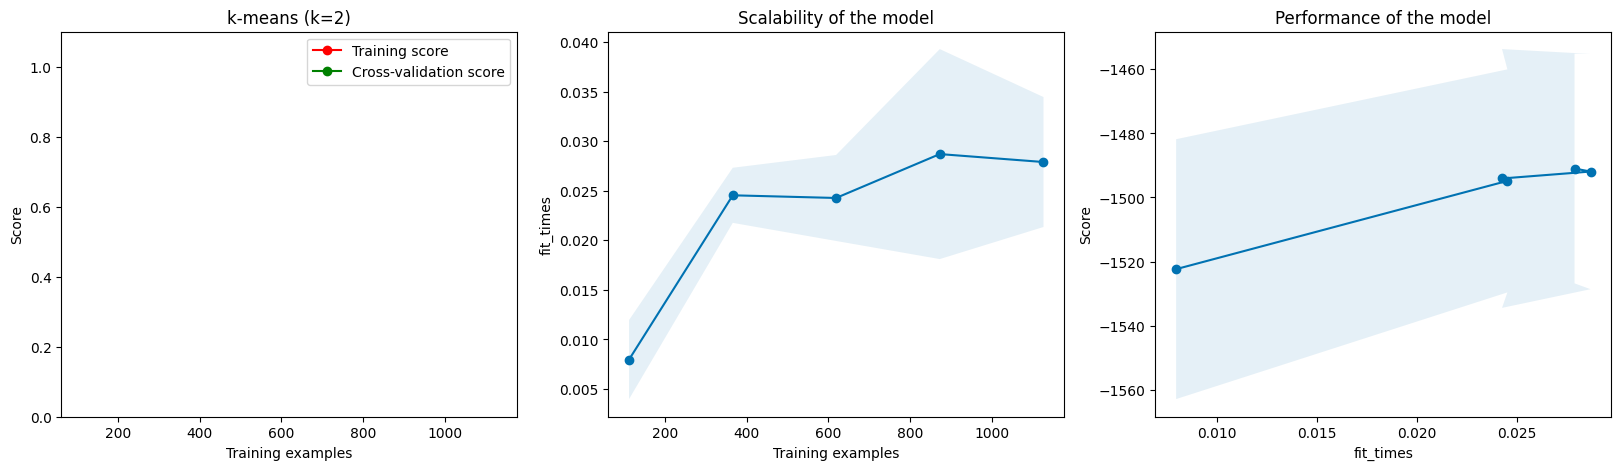

CPU times: user 8.43 s, sys: 5.14 s, total: 13.6 s
Wall time: 4.13 s


In [12]:
%%time
task = "k-means"

f1 = []
train_acc = []
test_acc = []
params = [2]

for k in params:
    print("K = ", k)
    clf = KMeans(n_clusters=2)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    result[task][k] = {
        "accuracy_score" : accuracy_score(y_test,y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred),
        "f1" : f1_score(y_test,y_pred, average='binary'),
        "training_acc": clf.score(x_train, y_train),
        "testing_acc": clf.score(x_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, x, y, cv=10, scoring='roc_auc'),
    }
    print("Accuracy: ", result[task][k]["accuracy_score"])
    print("ROC AUC score: ", result[task][k]["roc_auc"])
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    # print("Cross Validation Score")
    # print(result[task][k]["cross_validation_score"])

    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])
    
    # plot_learning_curve(clf, f"{task} (k={k})", x, y, axes=None, cv=10, n_jobs=4)
    # plt.savefig(f'mental_plots/learning_curve_{task}_{k}.png')
    # plt.show()
    
# # Validation Curve
# new_params = params
# plot_validation_curve(KMeans(), f"{task}: n_neighbors", x, y, "n_neighbors", new_params, scoring="accuracy", axes=None, cv=10, n_jobs=4)
# plt.savefig(f'mental_plots/validation_curve_{task}.png')
# plt.show()

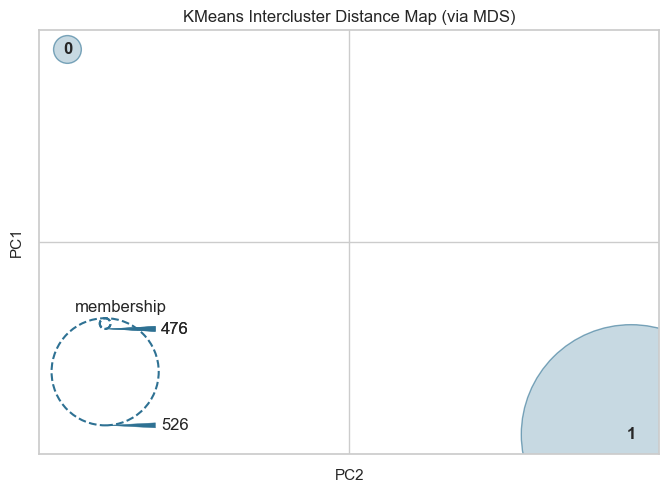

In [20]:
from yellowbrick.cluster import intercluster_distance
from yellowbrick.cluster import silhouette_visualizer

visualizer = intercluster_distance(KMeans(2), x_train)

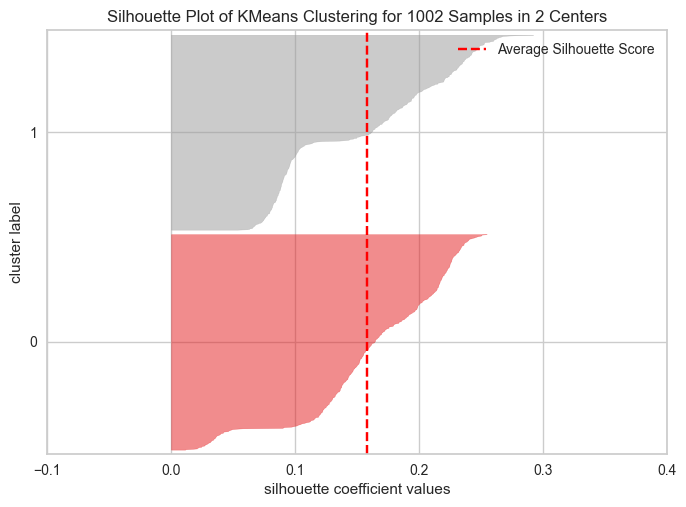

In [14]:
visualizer = silhouette_visualizer(KMeans(2, random_state=42), x_train)

In [15]:
from external_fn import *

In [16]:
scaler = preprocessing.StandardScaler().fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 6.91 µs


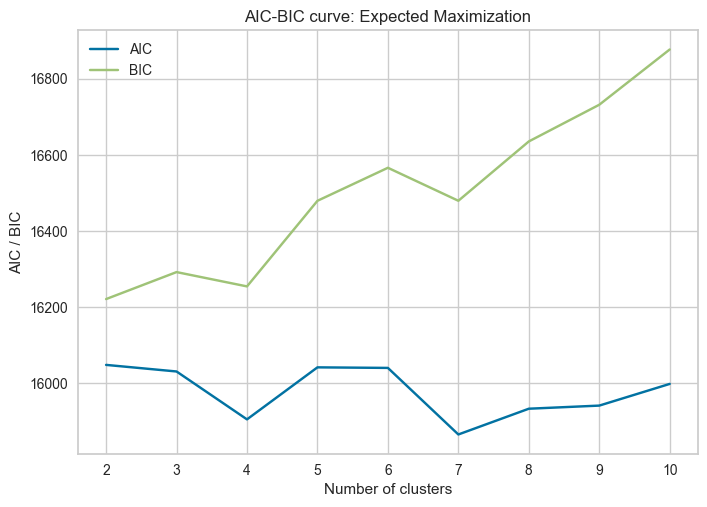

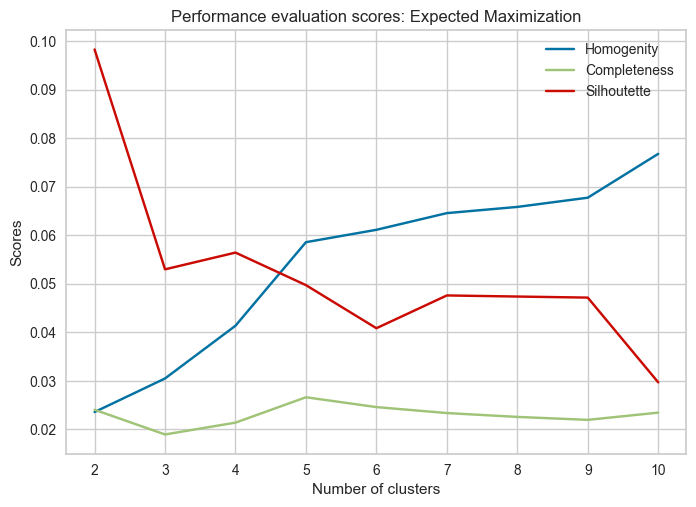

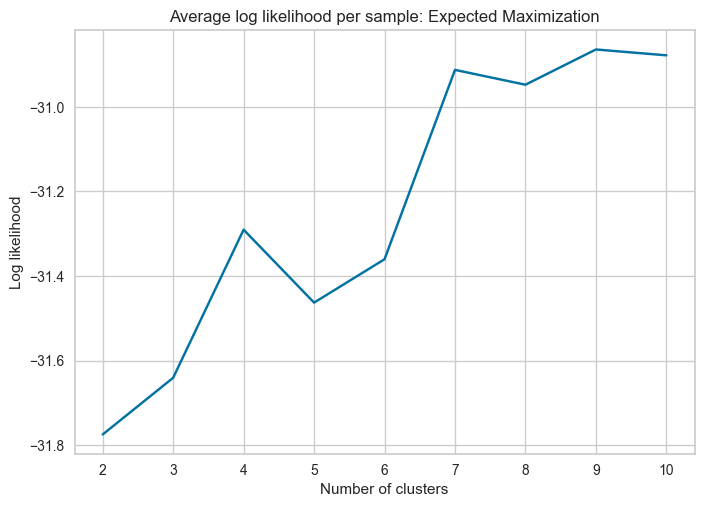

Training accuracy for Expected Maximization for K = 2:  61.97604790419161
Testing accuracy for Expected Maximization for K = 2:  58.964143426294825


([2, 3, 4, 5, 6, 7, 8, 9, 10],
 [16048.746468551108,
  16031.460873460966,
  15905.74226594306,
  16042.295396950616,
  16040.82708923387,
  15866.113126755321,
  15933.719134112922,
  15941.897517456398,
  15998.840229676829],
 [16221.493662568566,
  16292.344390956718,
  16254.762106917105,
  16479.45156140296,
  16566.119577164507,
  16479.54193816425,
  16635.284269000145,
  16731.59897582192,
  16876.678011520642],
 [0.023567884537654876,
  0.030490181330924872,
  0.041361696068608816,
  0.05857924049517399,
  0.061131384547986535,
  0.06457204879757152,
  0.06584817450334257,
  0.0677494739202561,
  0.07678924942904483],
 [0.02403642328797765,
  0.018946203278416358,
  0.021386364255363253,
  0.026615532138510374,
  0.024587641229708464,
  0.023362250549205366,
  0.022565151823797012,
  0.021956947935618965,
  0.02344768826267424],
 [0.09830077255987771,
  0.0529838857865246,
  0.05643376064471439,
  0.04972613242243251,
  0.04084514150257011,
  0.047602113370696204,
  0.04737543

In [21]:
%time
num_class = 2
means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(2)])
expectation_maximization(X_train, X_test, y_train, y_test, init_means = means_init, component_list = [2,3,4,5,6,7,8,9,10], num_class = 2)

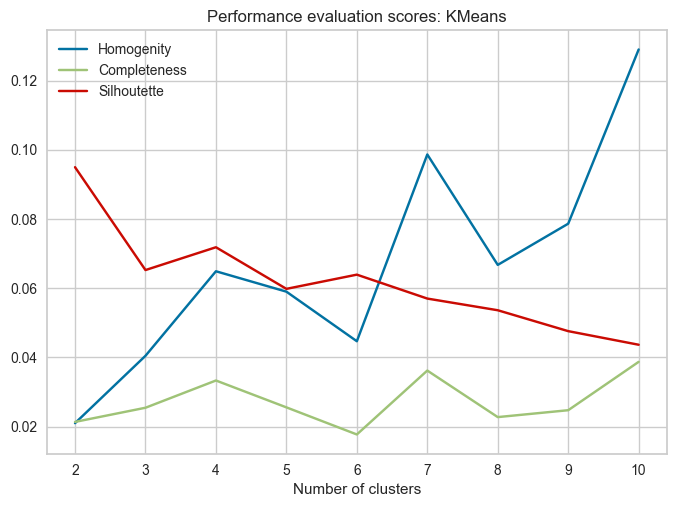

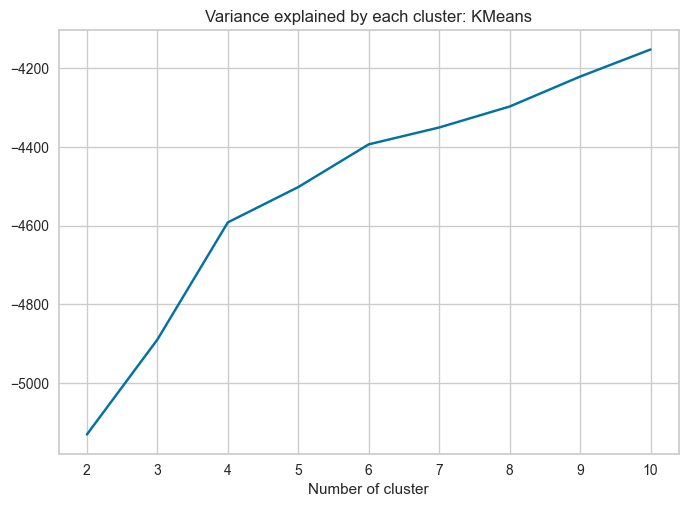

Training accuracy: KMeans - K = 2:  62.874251497005986
Testing accuracy for KMeans for K = 2:  56.17529880478087


([2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0.0210155493598962,
  0.04047786485836893,
  0.06490057148737831,
  0.05900861547789514,
  0.044685471050838005,
  0.09864002281658245,
  0.066739829086865,
  0.07864527700721144,
  0.1289753394946637],
 [0.02137769365681215,
  0.025472509777448023,
  0.033342315700057225,
  0.025580926110112475,
  0.017749753759712918,
  0.03621120550247075,
  0.022767698696014898,
  0.024758161520368097,
  0.038728891273307746],
 [0.09496910921290896,
  0.06524984712608789,
  0.07183912119129107,
  0.059816047959087654,
  0.06392287763087959,
  0.05701127708202082,
  0.053637933302208035,
  0.047600986972285965,
  0.04367154291526452],
 [-5131.292014653463,
  -4890.055914613024,
  -4591.862684265567,
  -4502.0026922499355,
  -4393.342607452258,
  -4350.444673334769,
  -4297.12021071307,
  -4220.9867847984115,
  -4152.012539032832])

In [23]:
kmeans(X_train, X_test, y_train, y_test, init_means = means_init, component_list = [2,3,4,5,6,7,8,9,10], num_class = 2)